In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community as cm

## 3.1 Introdução 

Uma das tarefas comum em análise de redes complexas é agrupar os vértices da rede em subconjuntos, chamados de comunidades, de modo que os vértices mais similares fiquem juntos em uma comunidade. 

A ideia central é entender um pouco sobre como os nós tendem a se organizar dentro da rede através da observação dos padrões de ligação que os mesmos possuem.

Problemas de detecção de comunidades são similares a problemas de partição em grafos, mas em geral nestes últimos já há uma quantidade pré-determinada de grupos e dos tamanhos dos mesmos no qual o grafo deve ser particionado, o que não ocorre em geral com os problemas de detecção de comunidades nos quais o tamanho e a quantidade de comunidades a serem detectadas não são previamente conhecidos

## 3.2 CONCOR

O método **CONCOR** foi um dos primeiros métodos e é um dos mais usados para detectar comunidades. 

Esse método é baseado na convergência de correlações iteradas.

O método **CONCOR** aplicado uma única vez, divide o conjunto de nós em no máximo duas comunidades. 
Se mais comunidades forem necessárias, pode-se aplicar novamente o método **CONCOR** em uma das comunidades encontrada anteriormente, dividindo-a em duas.

### Exemplo 1:

Considere a rede do livro 2 da saga Harry Potter. 

As ligações dessa rede representam suporte emocional e, portanto, trata-se de uma rede direcionada com matriz de adjacência não simétrica.

Usaremos o algoritmo **CONCOR** para achar uma divisão em duas comunidades.

In [24]:
# lendo os arquivos
atri = pd.read_csv('../../data/harrypotter/hpattributes.txt', sep='\t') 
ares = pd.read_csv('../../data/harrypotter/hpbook2.txt', sep=' ', header=None)
nome = pd.read_csv('../../data/harrypotter/hpnames.txt', sep='\t')

In [25]:
# criando o grafo(rede)
gpotter = nx.DiGraph()
n = atri.shape[0]

for k in range(n):
    gpotter.add_node(k,
                     nome = nome['name'][k],
                     ano = atri['schoolyear'][k],
                     gen = atri['gender'][k],
                     casa = atri['house'][k])

for k in range(n):
    for m in range(n):
        if ares.values[k][m] == 1:
            gpotter.add_edge(k,m)

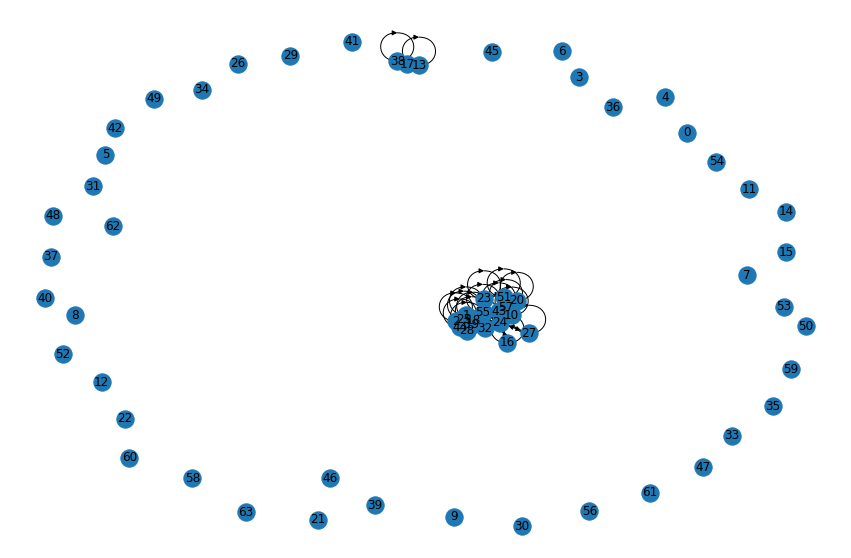

In [26]:
# gera o grafico da rede
fig, ax = plt.subplots(1, 1, figsize=(15,10))

nx.draw(gpotter, with_labels=True)

Observe que temos um número elevado de vértices isolados.

In [27]:
ldegree0 = []
for i in gpotter.nodes:
    if gpotter.degree[i] == 0:
        ldegree0.append(i)

print(ldegree0)
print(len(ldegree0))

[0, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 17, 21, 22, 26, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63]
44


In [28]:
# gerando a matriz de adjacência esparsa
#A = nx.adjacency_matrix(gpotter)
A = nx.to_scipy_sparse_array(gpotter).toarray()

#print(f"adjacency : \n {A}")
print(A)

[[0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Excluímos os nós isolados, pois estes vértices podem ser considerados uma comunidade separada, mas alguns deles correspondem a personagens que não fazem parte do livro.

In [29]:
# deletando os nodes isolados
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nos isolados')

44 nos isolados


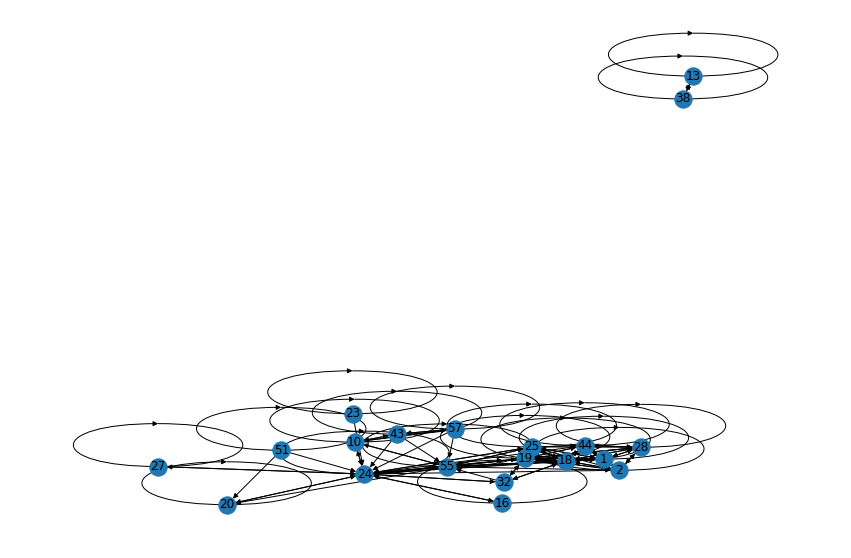

In [30]:
# grafico após eliminação dos vértices isolados
fig, ax = plt.subplots(1, 1, figsize=(15,10))

nx.draw(gpotter, with_labels=True)

In [32]:
# matriz de adjacencia esparsa
#A = nx.adjacency_matrix(gpotter)
A = nx.to_scipy_sparse_array(gpotter)#.toarray()

# matriz de adjacencia densa
A = np.array(A.todense(),dtype=float)
print(A)

[[1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.

A convergência do algoritmo é detectada usando a função **allclose** do **Numpy**. 
Quando trabalhamos com aritmética de ponto flutante, existe a possibilidade de que os elementos da matriz $C_k$ não fiquem exatamente iguais a +-1. 

As correlações são feitas usando a função **corrcoef** de Numpy. 

O método **adjacency_matrix**(**to_scipy_sparse_array**) devolve a matriz em um formato para matrizes esparsas, assim convertemos a matriz para um formato denso com método **todense**.

**allclose()**: retorna True se dois arrays forem iguais elemento por elemento dentro de uma tolerância.

**ones_like():** retorna um array de uns com o mesmo formato e tipo de um array fornecido.

 **corrcoef():** retorna os coeficientes de correlação produto-momento de Pearson.

In [ ]:
# algoritmo CONCOR
def concor(A):
    
    C = A.copy()
    while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
        C = np.corrcoef(C)

    C = np.round(C)

    return C

C = concor(A)

print(C)

[[ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
   1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
   1. -1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
   1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
   1. -1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
  -1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
   1. -1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.

In [ ]:
# algoritmo CONCOR completo
def concor_complet(G):
    for i in G.nodes:
        if G.degree[i] == 0:
            G.remove_node(i)

    A = nx.to_scipy_sparse_array(G)
    A = np.array(A.todense(),dtype=float)

    C = A.copy()
    while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
        C = np.corrcoef(C)

    C = np.round(C)

    return C

C = concor(gpotter)

print(C)

In [ ]:
com1 = [] # comunidade 1
com2 = [] # comunidade 1

nos  = list(gpotter.nodes)

com1.append(nos[0]) # adiciona o node 0

for k in range(1,len(nos)):
    if C[0,k] > 0:
        com1.append(nos[k])
    else:
        com2.append(nos[k])

print(f"#com1 = {len(com1)}, #com2 = {len(com2)}")

In [36]:
print('comunidade 1:')
for k in range(len(com1)):
    print(f"{com1[k]}: {gpotter.nodes[com1[k]]['nome']}")

comunidade 1:
1: Alicia Spinnet
2: Angelina Johnson
18: Fred Weasley
19: George Weasley
25: Hermione Granger
28: Katie Bell
32: Lee Jordan
44: Oliver Wood
55: Ronald Weasley


In [37]:
print('comunidade 2:')
for k in range(len(com2)):
    print(f"{com2[k]}: {gpotter.nodes[com2[k]]['nome']}")

comunidade 2:
10: Dean Thomas
13: Draco Malfoy
16: Ernie Macmillan
20: Ginny Weasley
23: Hannah Abbott
24: Harry James Potter
27: Justin Finch-Fletchley
38: Marcus Flint
43: Neville Longbottom
51: Percy Weasley
57: Seamus Finnigan


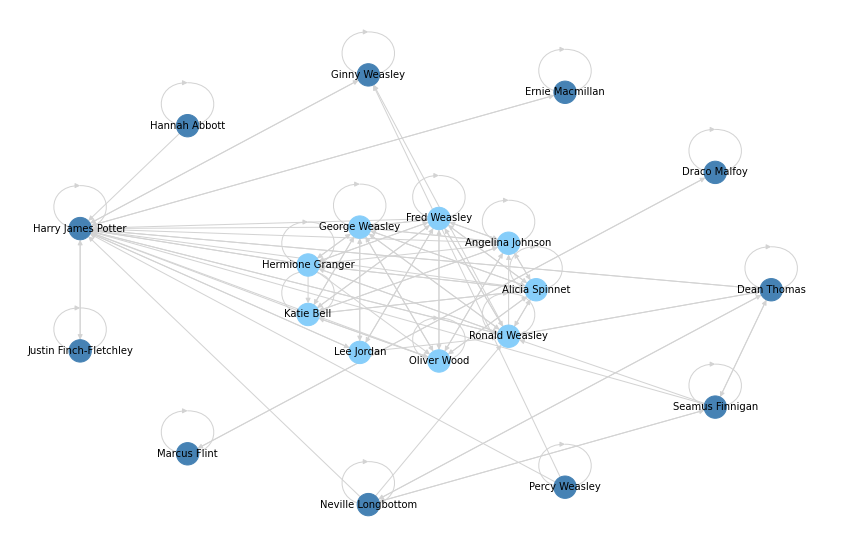

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 100*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 100*np.sin(2*np.pi*k/len(com1))

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size=500, labels=etiquetas,
                 font_size=10, node_color=cores)

plt.box(False)
plt.show()

### Exemplo 2

Os problemas partição de um grafo em comunidades são, comumente, muito complexos. 
Para contonar essa dificuldade, heurísticas foram desenvolvidas para resolver esse tipo de problema.

A função **heuristic_community** minimiza a razão entre o número de arestas que ligam dois grupos e o produto dos tamanhos dos dois grupos.

O pacote **algorithms.community** do **networkx** contém funções para calcular e medir a estrutura de comunidades em redes. 

Um exemplo é a função **partition_quality**, que retorna a razão entre o número de arestas internas aos grupos e o número total de arestas.

In [39]:
a,b = cm.partition_quality(gpotter,[com1,com2])
print(a)
print(b)

0.8454545454545455
0.7210526315789474


In [40]:
def heuristic_community(G):
    mper = np.inf
    for ini in G:
        com1 = set([ini])
        com2 = set(nos)-com1
    
        mgan = -1 # mgan = Delta
        while mgan < 0:
            mgan = np.inf
            cv, pe = cm.partition_quality(G,[com1,com2]) # calculo da razao 
            ra = (1-cv)/(len(com1)*len(com2)) # calcula da razao
            #print(f"cv={cv}, pe={pe}, ra={ra}")
            mno = -1

            for no in com2:
                ncom1 = com1.union(set([no]))
                ncom2 = com2-set([no])
                cv, pe = cm.partition_quality(G,[ncom1,ncom2])
                nra = (1-cv)/(len(ncom1)*len(ncom2)) #nra = delta
                ng = nra-ra

                if ng < mgan:
                    mgan = ng
                    mno  = no

            if mgan < 0:
                com1.add(mno)
                com2.remove(mno)
    
        cv, pe = cm.partition_quality(G,[com1,com2])            
        ra = (1-cv)/(len(com1)*len(com2)) 

        if ra < mper:
            mper = ra
            mcom1 = com1.copy()
            mcom2 = com2.copy()

    return mcom1, mcom2

In [41]:
mcom1, mcom2 = heuristic_community(gpotter)
com1 = list(mcom1)
com2 = list(mcom2)

In [42]:
print(f"comunidade 1:")
for k in range(len(com1)):
    print(f"{com1[k]}: {gpotter.nodes[com1[k]]['nome']}")

comunidade 1:
13: Draco Malfoy
38: Marcus Flint


In [43]:
print(f"comunidade 2:")
for k in range(len(com2)):
    print(f"{com2[k]}: {gpotter.nodes[com2[k]]['nome']}")

comunidade 2:
1: Alicia Spinnet
2: Angelina Johnson
10: Dean Thomas
16: Ernie Macmillan
18: Fred Weasley
19: George Weasley
20: Ginny Weasley
23: Hannah Abbott
24: Harry James Potter
25: Hermione Granger
27: Justin Finch-Fletchley
28: Katie Bell
32: Lee Jordan
43: Neville Longbottom
44: Oliver Wood
51: Percy Weasley
55: Ronald Weasley
57: Seamus Finnigan


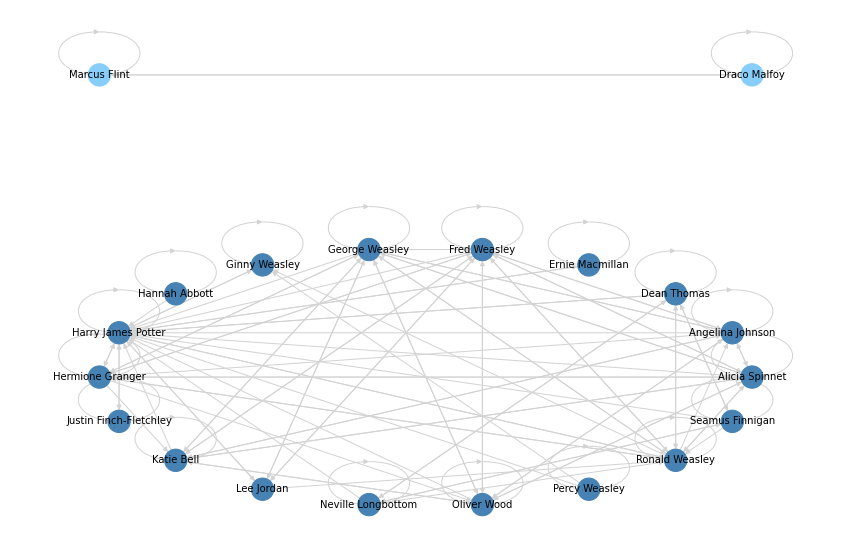

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500, 
                 labels=etiquetas,
                 font_size=10, 
                 node_color=cores)

plt.box(False)
plt.show()

## 3.3 Algoritmo de Kernighan-Lin

Um algoritmo de bisseção muito conhecido é o algoritmo de **Kernighan e Lin**. 

Este algoritmo começa com uma partição do grafo e prossegue trocando dois nós, um de cada grupo, de maneira de aprimorar a partição.

No **networkx** está implementado o métodos **kernighan_lin_bisection**, o qual retorna a particão de um grafo em dois blocos usando o algoritmo **Kernighan-Lin**.

Este algoritmo particiona uma rede em dois conjuntos trocando iterativamente pares de nós para reduzir o corte de arestas entre os dois conjuntos.

Os pares são escolhidos de acordo com uma forma modificada do **Kernighan-Lin**, que move os nós individualmente, alternando entre os lados para manter a bisseção equilibrada.

Considere uma rede com um conjunto de nós $V$ e seja $G_1$ , $G_2 \subseteq V$ uma partição de $V$. 

Sejam $I_k$ e $E_k$ os números de arestas associadas ao nó $k$ que são internas e externas ao grupo ao qual $k$ pertence, respectivamente.
Em cada passo, o algoritmo procura encontrar o par $(i,j) \in G_1 \times G_2$ que maximize  $\Delta_{ij} = E_i − I_i + E_j − I_j − 2 \cdot C_{ij}$ , onde $C_{ij}$ é o número de arestas entre $i$ e $j$.

Observe que $\Delta_{ij}$ é o valor da redução do número de arestas entre grupos ao se trocar os nós $i$ e $j$ de grupos.

O algoritmo de **Kernighan-Lin** assume que a rede é não direcionada, e é necessário determinar o número de vértices em cada grupo como entrada ao algoritmo ou grupos aproximadamente iguais são escolhidos aleatoriamente.

O algoritmo finaliza quando não existem nós $i$ e $j$ que possam ser trocados de grupo e diminuir o valor da função objetivo, ou após um número fixo de iterações pré-estabelecido.

### Exemplo 4
Aplicação do algoritmo **Kernighan-Lin** do **networkx** a uma rede de personagens do livro 2 da saga Harry Potter.

In [50]:
# algoritmo Kernighan-Lin aplicado a uma rede
com1, com2 = cm.kernighan_lin_bisection(gpotter.to_undirected(), max_iter=100)

print(f"com1: {com1}")
print(f"com2: {com2}")

com1: {38, 10, 43, 13, 16, 51, 20, 23, 57, 27}
com2: {32, 1, 2, 44, 18, 19, 55, 24, 25, 28}


In [51]:
print('comunidade 1:')
for k in com1:
    print(f"{k}: {gpotter.nodes[k]['nome']}")

comunidade 1:
38: Marcus Flint
10: Dean Thomas
43: Neville Longbottom
13: Draco Malfoy
16: Ernie Macmillan
51: Percy Weasley
20: Ginny Weasley
23: Hannah Abbott
57: Seamus Finnigan
27: Justin Finch-Fletchley


In [52]:
print('Comunidade 2:')
for k in com2:
    print(f"{k}: {gpotter.nodes[k]['nome']}")

Comunidade 2:
32: Lee Jordan
1: Alicia Spinnet
2: Angelina Johnson
44: Oliver Wood
18: Fred Weasley
19: George Weasley
55: Ronald Weasley
24: Harry James Potter
25: Hermione Granger
28: Katie Bell


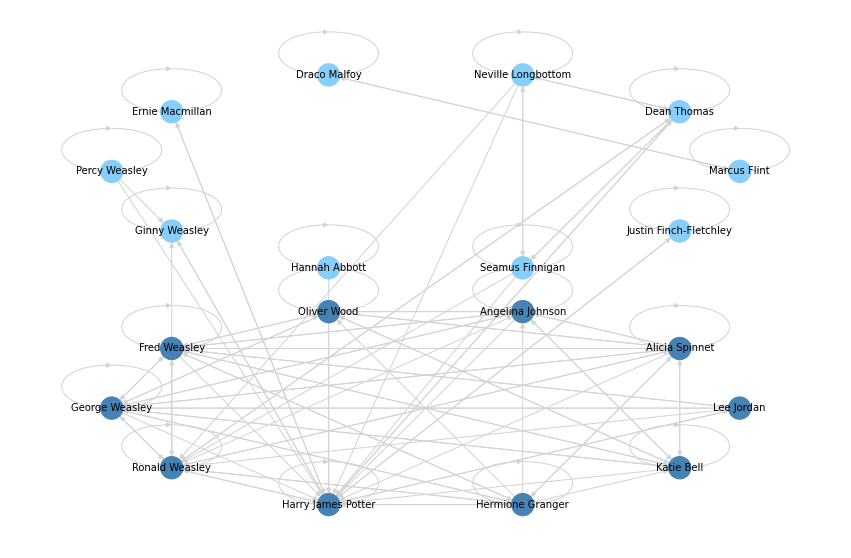

In [53]:
com1 = list(com1)
com2 = list(com2)

fig, ax = plt.subplots(1, 1, figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()

### Exemplo 5
Cálculo de comunidades para o Karate Club Graph.

In [55]:
KCG = nx.karate_club_graph()

In [58]:
# algoritmo Kernighan-Lin aplicado a uma rede
com1, com2 = cm.kernighan_lin_bisection(KCG.to_undirected(), max_iter=100)

print(f"com1: {com1}")
print(f"com2: {com2}")

print(f"#com1 = ", len(com1))
print(f"#com1 = ", len(com2))

com1: {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21}
com2: {32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
#com1 =  17
#com1 =  17


In [64]:
for i in KCG:
    print(f"{i} = {KCG.degree[i]}")

0 = 16
1 = 9
2 = 10
3 = 6
4 = 3
5 = 4
6 = 4
7 = 4
8 = 5
9 = 2
10 = 3
11 = 1
12 = 2
13 = 5
14 = 2
15 = 2
16 = 2
17 = 2
18 = 2
19 = 3
20 = 2
21 = 2
22 = 2
23 = 5
24 = 3
25 = 3
26 = 2
27 = 4
28 = 3
29 = 4
30 = 4
31 = 6
32 = 12
33 = 17


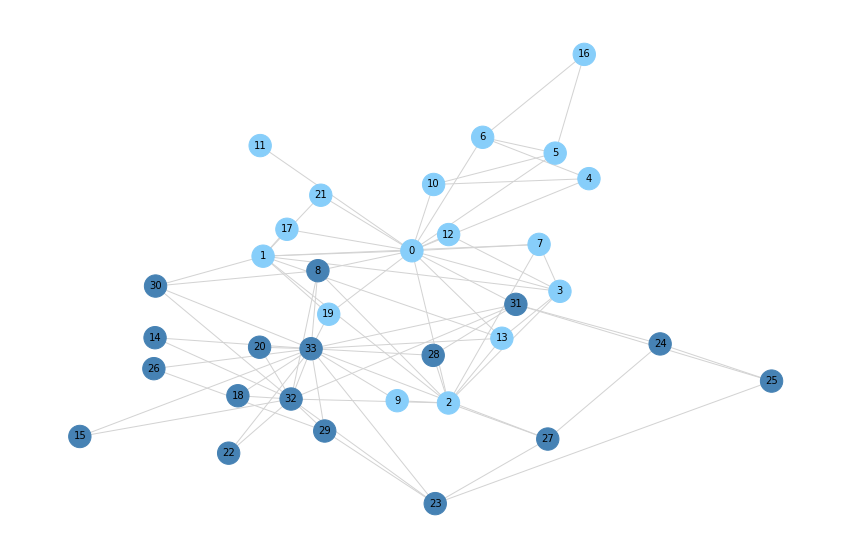

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

pos = nx.kamada_kawai_layout(KCG)

cores = []
for no in KCG.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

#etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(KCG, pos=pos, edge_color='lightgray',
                 node_size=500, with_labels=True,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()

In [84]:
# algoritmo CONCOR completo
def concor_complet(G):
    for i in G.nodes:
        if G.degree[i] == 0:
            G.remove_node(i)

    A = nx.to_scipy_sparse_array(G)
    A = np.array(A.todense(),dtype=float)

    C = A.copy()
    while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
        C = np.corrcoef(C)

    C = np.round(C)

    com1 = [] # comunidade 1
    com2 = [] # comunidade 2

    nos  = list(G.nodes)

    com1.append(nos[0]) # add node 0 a com1

    for k in range(1,len(nos)):
        if C[0,k] > 0:
            com1.append(nos[k])
        else:
            com2.append(nos[k])

    return com1, com2

In [88]:
concor_com1, concor_com2 = concor_complet(KCG)

print(f"#concor_com1 = {len(concor_com1)}")
print(f"#concor_com2 = {len(concor_com2)}")
print(f"#concor_com1 = {concor_com1}")
print(f"#concor_com2 = {concor_com2}")

#concor_com1 = 16
#concor_com2 = 18
#concor_com1 = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
#concor_com2 = [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


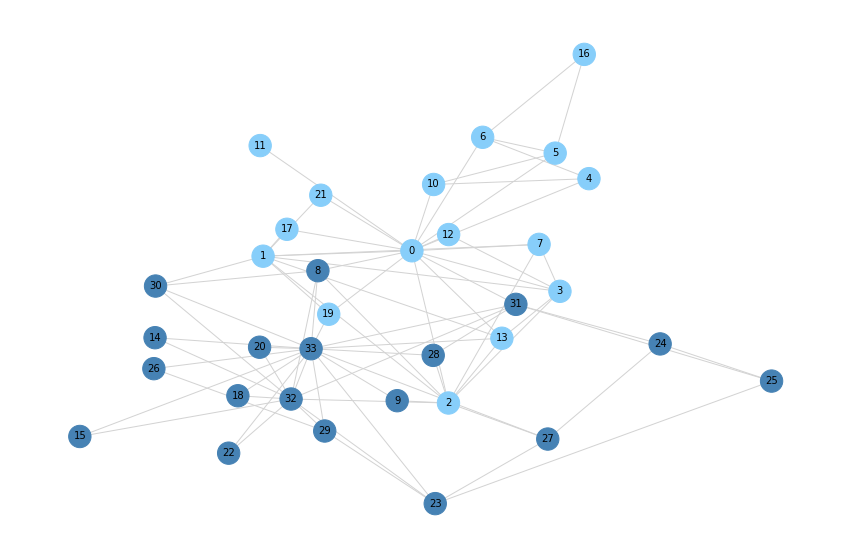

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

pos = nx.kamada_kawai_layout(KCG)

cores = []
for no in KCG.nodes():
    if no in concor_com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

#etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(KCG, pos=pos, edge_color='lightgray',
                 node_size=500, with_labels=True,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()